# PyTorchを使った機械学習 （ml_00~ml_05）

- [PyTorch＆深層学習プログラミング](https://www.amazon.co.jp/dp/4296110322)

１次関数にフィッティングさせる。

簡単な例として、５人の身長と体重をデータとして与え、その関係を一次関数（$y = W x + b）$ という関数で表現することを考える。

- スカラの重み/スカラのバイアス/隠れ層なし、で学習させる。
- ここでの考え方は、重みやバイアス、隠れ層がテンソルになっても同じ。


## 勾配降下法

特定の関数にフィッテングさせるというのは、関数のパラメタ値を適切な値に決定することである。

パラメタ値を探索する際、**損失関数** という指標に基づいてパラメタを決定する。
教師データと、現時点でのパラメタ値による予測値のズレを損失関数にする。
今回の関数のフィッテイングには、教師データと予測値の二乗和平均を使う（つまり、
やっていることは、単なる最小二乗法である）。

その際、パラメタ値の変更を、損失関数の微分値に基づいて変化させる（最小化する方向に
パラメタを更新）方法を、**勾配降下法** と呼ぶ。ただし、局所的な最小値がある場合、
大局的な最小値に到達できない可能性もある。

In [22]:
# !pip install torchviz | tail -1

In [23]:
import numpy as np
import torch
from torchviz import make_dot
import matplotlib.pyplot as plt
import japanize_matplotlib

### 入力データ

５人の身長と体重をデータの散布図を表示する

In [24]:
data = np.array([
    [166.0, 58.7],
    [176.0, 75.7],
    [171.0, 62.1],
    [173.0, 70.4],
    [169.0, 60.1],
])

x = data[:, 0]
y = data[:, 1]

(58.7, 75.7)

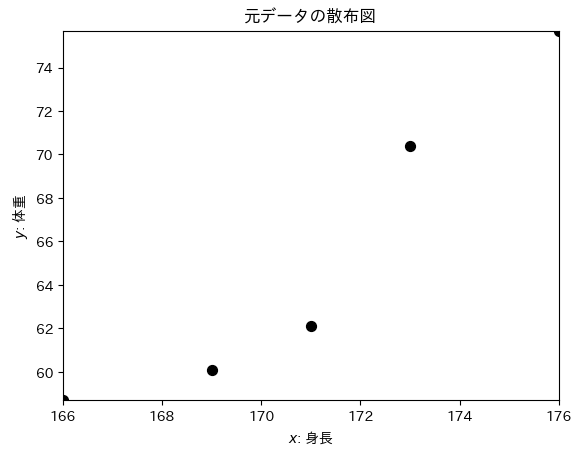

In [25]:
plt.title('元データの散布図')
plt.scatter(x, y, c='k', s=50)
plt.xlabel('$x$: 身長')
plt.ylabel('$y$: 体重')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

#### データの正規化

与えられたデータ列 $\left\{x_i\right\}_{i=1}^n$ を $[0, 1]$ の区間にアフィン変換することを **正規化** と呼ぶ。

具体的には、以下の変換をする。

$x_i' = \cfrac{x_i - \min_{j} x_j}{\max_{j} x_j + \min_{j} x_j}$

他にも、正規分布にしたがうとみなして、$x_i = \cfrac{x_i - \mu}{\sigma}$ という変換を **標準化** と呼ぶ。

ただし $\mu = \cfrac{1}{n}\sum_{i=1}^n x_i,\ \sigma = \cfrac{1}{n}\sqrt{\sum_{i=1}^n (x_i - \mu)^2}$ で、それぞれ、
平均と標準偏差である。

このように、機械学習し易いように、データの前処理を行うことを **特徴量エンジニアリング** と呼んでいる。

この他にも、欠損値の処理や、カテゴリ変数に対してOne-Hotエンコーディングを施すなどがある。

(0.0, 1.0)

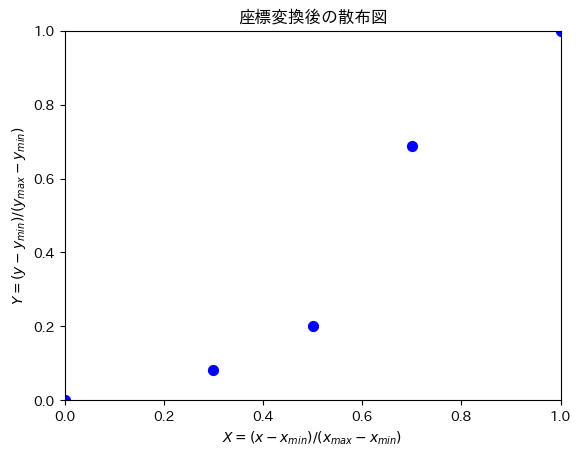

In [26]:
##### normalizeをしないと、値が大きすぎて、計算結果が発散してしまう！
X = (x - x.min()) / (x.max() - x.min())
Y = (y - y.min()) / (y.max() - y.min())

plt.title('座標変換後の散布図')
plt.scatter(X, Y, c='b', s=50)
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())

### １エポック分の処理

PyTorchでは、数学的な詳細を何も知らなくても利用できるよう、**テンソル** と呼ばれる
多次元配列のデータ構造が提供されている。数学や物理学で出てくるテンソルのように、
特定の概念をもったモノではなく、単なる多次元配列という理解で十分なように作られている。

テンソルを使うと **自動微分** を使うことができる。単に何らかの計算するだけで、
その計算過程を表現する、計算グラフが内部的に構築される。これに基づいて、勾配
（各軸方向への偏微分を成分とするベクトル）を計算してくれる。

In [27]:
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

W = torch.tensor(1.0, requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()

#### 予測関数（モデル）の定義と計算グラフ

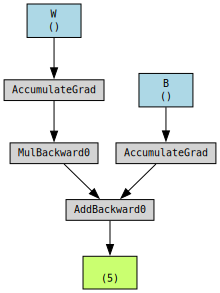

In [28]:
def pred(X, W, B):
    return W * X + B

Yp = pred(X, W, B)

params = {'W': W, 'B': B}
g = make_dot(Yp, params=params)

display(g)

#### 損失関数の定義と計算グラフ

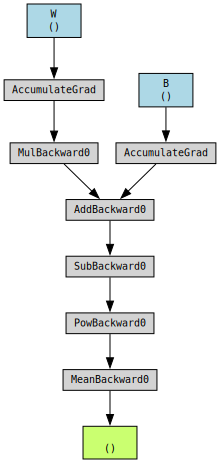

In [29]:
def mse(Yp, Y):
    loss = ((Yp - Y) ** 2).mean()
    return loss

loss = mse(Yp, Y)

g = make_dot(loss, params=params)

display(g)

#### 勾配の計算

In [30]:
loss.backward()

#### 勾配をもとにパラメタ値の更新

In [31]:
lr = 0.001

# 手動で勾配から計算する、いちばん原始的な方法
with torch.no_grad():
    W -= lr * W.grad
    B -= lr * B.grad
    W.grad.zero_()
    B.grad.zero_()


### 複数回、繰り返してパラメタの精度を上げる

In [32]:
W = torch.tensor(1.0, requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()

num_epochs = 2000

lr = 0.001

history = np.zeros((0, 2))

In [33]:
for epoch in range(num_epochs):
    Yp = pred(X, W, B)
    loss = mse(Yp, Y)
    loss.backward()
    ##### この過程をoptimizerを使って自動化することができる
    with torch.no_grad():
        W -= lr * W.grad
        B -= lr * B.grad
        W.grad.zero_()
        B.grad.zero_()
    #####
    if epoch % 10 == 0:
        item = [epoch, loss.item()]
        history = np.vstack((history, item)) # historyにitemを列方向（axis=0）へ追加してゆく
        if epoch % 100 == 0:
            print(f'epoch: {epoch} / loss: {loss:.4f} / (W, B) = ({W.item():.2f}, {B.item():.2f})')

print(f'W = {W.data.numpy()}')
print(f'B = {B.data.numpy()}')

print(f'init: loss = {history[0, 1]:.4f}')
print(f'last: loss = {history[-1, 1]:.4f}')

epoch: 0 / loss: 1.2393 / (W, B) = (1.00, 1.00)
epoch: 100 / loss: 0.7624 / (W, B) = (0.90, 0.80)
epoch: 200 / loss: 0.4758 / (W, B) = (0.83, 0.65)
epoch: 300 / loss: 0.3033 / (W, B) = (0.78, 0.53)
epoch: 400 / loss: 0.1994 / (W, B) = (0.74, 0.44)
epoch: 500 / loss: 0.1367 / (W, B) = (0.71, 0.36)
epoch: 600 / loss: 0.0987 / (W, B) = (0.69, 0.31)
epoch: 700 / loss: 0.0755 / (W, B) = (0.68, 0.26)
epoch: 800 / loss: 0.0612 / (W, B) = (0.67, 0.22)
epoch: 900 / loss: 0.0523 / (W, B) = (0.66, 0.19)
epoch: 1000 / loss: 0.0466 / (W, B) = (0.66, 0.17)
epoch: 1100 / loss: 0.0429 / (W, B) = (0.66, 0.15)
epoch: 1200 / loss: 0.0403 / (W, B) = (0.66, 0.14)
epoch: 1300 / loss: 0.0385 / (W, B) = (0.66, 0.12)
epoch: 1400 / loss: 0.0371 / (W, B) = (0.67, 0.11)
epoch: 1500 / loss: 0.0360 / (W, B) = (0.67, 0.10)
epoch: 1600 / loss: 0.0351 / (W, B) = (0.68, 0.09)
epoch: 1700 / loss: 0.0343 / (W, B) = (0.68, 0.09)
epoch: 1800 / loss: 0.0335 / (W, B) = (0.69, 0.08)
epoch: 1900 / loss: 0.0329 / (W, B) = (0.70

繰り返しの回数を **エポック** と呼ぶ。
エポックが増えると、損失関数値が減少してゆく。

悪いモデルだと、その限りではない。

(0.0, 2000.0)

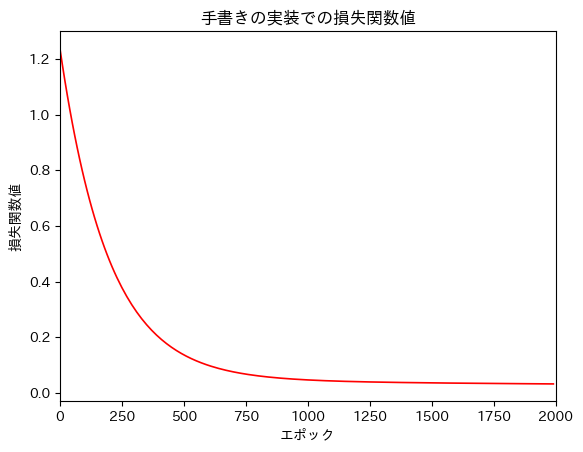

In [34]:
plt.title('手書きの実装での損失関数値')
plt.plot(history[:, 0], history[:, 1], 'r')
plt.xlabel('エポック')
plt.ylabel('損失関数値')
plt.xlim(0, num_epochs)


Text(0, 0.5, '$Y = (y - y_{min}) / (y_{max} - y_{min})$')

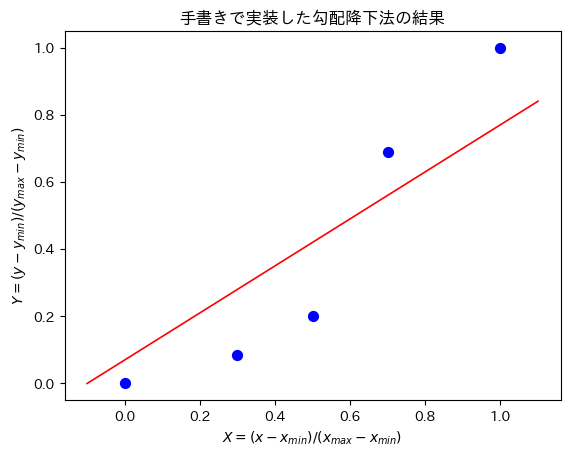

In [35]:
xx = np.arange(X.min() - 0.1, X.max() + 0.1, 0.01)
yy = W.item() * xx + B.item()

plt.title('手書きで実装した勾配降下法の結果')
plt.scatter(X, Y, c='b', s=50)
plt.plot(xx, yy, c='red')
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')



### パラメタ更新過程に関して、既存パッケージを使うことで精度を高める

ここではSDGというパラメタ更新方法を使う

In [36]:
W2 = torch.tensor(1.0, requires_grad=True).float()
B2 = torch.tensor(1.0, requires_grad=True).float()

In [37]:
import torch.optim as optim

optimizer = optim.SGD([W2, B2], lr=lr, momentum=0.9)
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
history2 = np.zeros((0, 2))

for epoch in range(num_epochs):
    Yp = pred(X, W2, B2)
    loss = mse(Yp, Y)
    loss.backward()
    ##### ここがoptimizerを使った部分
    optimizer.step()
    optimizer.zero_grad()
    #####
    if epoch % 10 == 0:
        item = [epoch, loss.item()]
        history2 = np.vstack((history2, item))
        if epoch % 100 == 0:
            print(f'epoch: {epoch} / loss: {loss:.4f} / (W2, B2) = ({W2.item():.2f}, {B2.item():.2f})')


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


epoch: 0 / loss: 1.2393 / (W2, B2) = (1.00, 1.00)
epoch: 100 / loss: 0.0418 / (W2, B2) = (0.64, 0.14)
epoch: 200 / loss: 0.0325 / (W2, B2) = (0.70, 0.07)
epoch: 300 / loss: 0.0273 / (W2, B2) = (0.76, 0.03)
epoch: 400 / loss: 0.0237 / (W2, B2) = (0.81, 0.00)
epoch: 500 / loss: 0.0212 / (W2, B2) = (0.86, -0.02)
epoch: 600 / loss: 0.0195 / (W2, B2) = (0.89, -0.04)
epoch: 700 / loss: 0.0183 / (W2, B2) = (0.92, -0.06)
epoch: 800 / loss: 0.0175 / (W2, B2) = (0.95, -0.07)
epoch: 900 / loss: 0.0170 / (W2, B2) = (0.97, -0.08)
epoch: 1000 / loss: 0.0166 / (W2, B2) = (0.99, -0.09)
epoch: 1100 / loss: 0.0163 / (W2, B2) = (1.00, -0.10)
epoch: 1200 / loss: 0.0161 / (W2, B2) = (1.01, -0.11)
epoch: 1300 / loss: 0.0160 / (W2, B2) = (1.02, -0.11)
epoch: 1400 / loss: 0.0159 / (W2, B2) = (1.03, -0.12)
epoch: 1500 / loss: 0.0158 / (W2, B2) = (1.04, -0.12)
epoch: 1600 / loss: 0.0158 / (W2, B2) = (1.04, -0.13)
epoch: 1700 / loss: 0.0158 / (W2, B2) = (1.05, -0.13)
epoch: 1800 / loss: 0.0158 / (W2, B2) = (1.05

In [38]:
print(f'W2 = {W2.data.numpy()}')
print(f'B2 = {B2.data.numpy()}')

print(f'init: loss = {history2[0, 1]:.4f}')
print(f'last: loss = {history2[-1, 1]:.4f}')

W2 = 1.0575584173202515
B2 = -0.13398928940296173
init: loss = 1.2393
last: loss = 0.0157


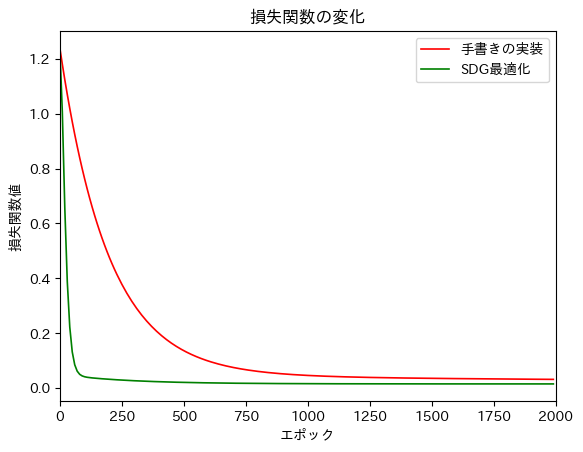

In [39]:
plt.title('損失関数の変化')
plt.xlabel('エポック')
plt.ylabel('損失関数値')
plt.plot(history[:, 0], history[:, 1], 'r', label='手書きの実装')
plt.plot(history2[:, 0], history2[:, 1], 'g', label='SDG最適化')
plt.xlim(0, num_epochs)
plt.legend()

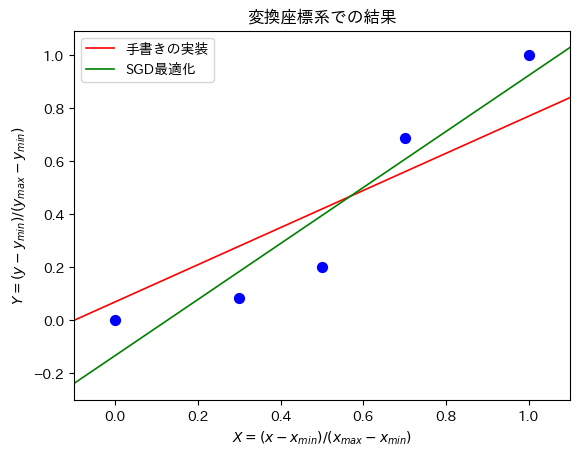

In [40]:
xx = np.arange(X.min() - 0.1, X.max() + 0.1, 0.01)
y1 = W.item() * xx + B.item()
y2 = W2.item() * xx + B2.item()

plt.title('変換座標系での結果')
plt.scatter(X, Y, c='blue', s=50)
plt.plot(xx, y1, c='red', label='手書きの実装')
plt.plot(xx, y2, c='green', label='SGD最適化')
plt.xlim(xx.min(), xx.max())
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')
plt.legend()


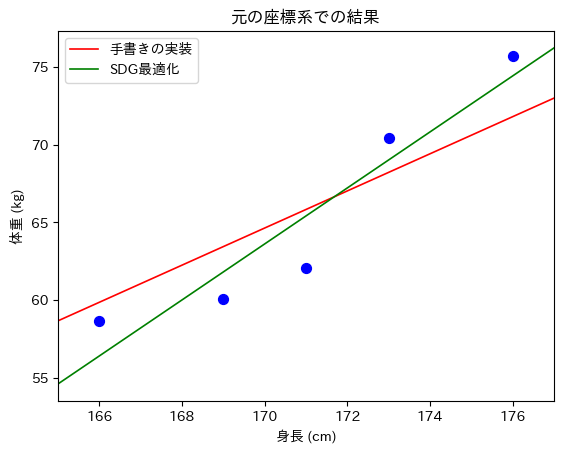

In [41]:
xx = xx * (x.max() - x.min()) + x.min()
y1 = y1 * (y.max() - y.min()) + y.min()
y2 = y2 * (y.max() - y.min()) + y.min()

plt.title('元の座標系での結果')
plt.scatter(x, y, c='blue', s=50)
plt.plot(xx, y1, c='red', label='手書きの実装')
plt.plot(xx, y2, c='green', label='SDG最適化')
plt.xlim(xx.min(), xx.max())
plt.xlabel('身長 (cm)')
plt.ylabel('体重 (kg)')
plt.legend()
